In [1]:
from dolfin import *
from ufl import le
import ufl
import operator
import numpy as np
from scipy.sparse.linalg import eigs
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
if not os.path.exists("./Experiment2b-Plots"):
    os.makedirs("./Experiment2b-Plots")

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# Q-Tensor parameters
n = 2
num_steps = 2000
T = 20.0
dt = T/num_steps
a = -0.3
b = -4.
c = 4.
M = 1.
L = 0.001

electric_field_size = 0.7

# Parameters for electric field                                       
R = 3.
eps2 = 0.25
eps3 = L/20#0.01
eps1 = 1.

# Parameters for convex splitting
beta1 = 8.
beta2 = 8.

In [3]:
# Create mesh
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), 30, 30)

In [4]:
# some functions for the scheme
I = Constant(np.eye(n)) # identity matrix
Zero = 0 * I
Zero_func = 0*Function(FunctionSpace(mesh, "Lagrange", 1))

def dF1_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = beta1 * Q - b*(Q2 - 1/n * trQ2 * I) + beta2 * trQ2 * Q
    return result

def dF2_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = (beta1 - a) * Q + (beta2 - c) * trQ2 * Q
    return result

def F_tot(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    trQ3 = tr(Q2*Q)
    result = a/2 * trQ2 - b/3 * trQ3 + c/4 * trQ2**2
    return result

def tens(Q):
    """
    Make vector function into tensor
    """
    return as_tensor([[Q[0], Q[1]],
                      [Q[1], -1*Q[0]]])

def tens_hi(Q):
    return as_tensor([[Q[0], Q[1]],
                      [Zero_func, Zero_func]])

def tens_lo(Q):
    return as_tensor([[Zero_func, Zero_func],
                      [Q[0], Q[1]]])

# approximate Heaviside function
steepness = 5

def H_(x):
    return 1/np.pi * atan(steepness * x) + 0.5

def DH_(x):
    return 1/np.pi * steepness / (1 + (steepness * x)**2)

# truncation of one component to R/d, d=2
def TR_1D(x):
    return x * H_(R/2-x) * H_(R/2+x) + R/2*H_(x-R/2) - R/2*H_(-x-R/2)

# derivative of TR_1D
def calP_1D(x):
    return H_(R/2-x)*H_(R/2+x) - x*DH_(R/2-x)*H_(R/2+x) + x*H_(R/2-x)*DH_(R/2+x) + R/2*DH_(x-R/2) + R/2*DH_(-x-R/2)

# now if Q is a tensor
def TR(Q):
    return as_tensor([[TR_1D(Q[0, 0]), TR_1D(Q[0, 1])], 
                      [TR_1D(Q[1, 0]), TR_1D(Q[1, 1])]])

def calP(Q):
    return as_tensor([[calP_1D(Q[0, 0]), calP_1D(Q[0, 1])], 
                      [calP_1D(Q[1, 0]), calP_1D(Q[1, 1])]])

def calP_h(Q1, Q0):
    P11 = calP_1D(Q0[0, 0])
    P12 = calP_1D(Q0[0, 1])
    P21 = calP_1D(Q0[1, 0])
    P22 = calP_1D(Q0[1, 1])
    
    res = as_tensor([[P11, P12],
                      [P21, P22]])
    return res

def element_mult(A, B):
    return as_tensor([[A[0, 0] * B[0, 0], A[0, 1] * B[0, 1]], 
                      [A[1, 0] * B[1, 0], A[1, 1] * B[1, 1]]])

## Initialize $Q_h^0$ and $u_h^0$

In [5]:
# initial conditions for the Q tensor
class InitialConditions(UserExpression):
    def eval(self, values, x):
        x, y = x[0], x[1]
        if np.isclose(x, -0.5) or np.isclose(x, 0.5) or np.isclose(y, -0.5) or np.isclose(y, 0.5):
            values[0] = 0.0
            values[1] = 0.0
        else:
            n0 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            n1 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            d = np.array([[n0], [n1]]) # director
            Q0 = d @ d.T - np.sum(d*d)/2.0 * np.eye(2) # Q tensor

            values[0] = Q0[0, 0]
            values[1] = Q0[0, 1]
    def value_shape(self):
        return (2,)

In [6]:
# initialize Q tensor at time 0
Q0 = Function(VectorFunctionSpace(mesh, "Lagrange", 1, dim=2))
Q_init = InitialConditions()
Q0.interpolate(Q_init)

# define uninitialized u0 and linear form to solve for u0
u_space = FunctionSpace(mesh, "Lagrange", 1)
u0 = Function(u_space)
v = TestFunction(u_space)

L_elliptic = inner(grad(u0) + eps2*TR(tens(Q0))*grad(u0) + eps3*div(tens(Q0)), grad(v))*dx

# define boundary condition for u0
t = 0.0
u_b = Expression(f'{electric_field_size*t}*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
bc_u = DirichletBC(u_space, u_b, DomainBoundary())

# solve for u0
solve(L_elliptic == 0, u0, bc_u)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.252e-08 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.940e-22 (tol = 1.000e-10) r (rel) = 9.501e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


# Define and solve scheme

In [7]:
class QTensorEquation(NonlinearProblem):
    def __init__(self, L, a, bcs):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.bcs = bcs
    def F(self, b, x):
        assemble(self.L, tensor=b)
        for bc in self.bcs:
            bc.apply(b,x)
    def J(self, A, x):
        assemble(self.a, tensor=A)
        for bc in self.bcs:
            bc.apply(A)

In [8]:
Q_space = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim=2)
u_space = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = MixedElement(Q_space, u_space)
V = FunctionSpace(mesh, ME)

In [9]:
# Define trial and test functions
dQu = TrialFunction(V)
q, v = TestFunctions(V)
r, _ = TestFunctions(V)

# Define functions
Qu = Function(V)

# Split mixed functions
dQ, du = split(dQu)
Q, u = split(Qu)

In [10]:
# Weak statement of the equation
L_form = inner(tens(Q - Q0), tens(q))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens(q)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens(q))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens(q))*dx\
    - M*eps2*dt/2*(inner(element_mult(calP_h(tens(Q), tens(Q0)), outer(grad(u0), grad(u))) - (1/n)*tr(element_mult(calP_h(tens(Q), tens(Q0)), outer(grad(u0), grad(u))))*I, tens(q))*dx)\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens(q))))*dx)\
    + dt*inner(grad(u) + eps2*TR(tens(Q))*grad(u) + eps3*div(tens(Q)), grad(v))*dx

a_form = derivative(L_form, Qu, dQu)

In [11]:
# boundary conditions for Q do not change
bc_Q = DirichletBC(V.sub(0), np.zeros(2), DomainBoundary())

# Store solutions and times
Q_array = Q0.vector()[:].reshape(-1, 2)
Q_11 = Q_array[:, 0]
Q_12 = Q_array[:, 1]
solutions_Q = [np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1)]
solutions_u = [np.array(u0.vector()[:].reshape(-1, 1))]
times = [0.0]

solver = NewtonSolver()

t = 0.0
while (t < T):
    print(t)
    t += dt
    times.append(t)
    
    u_b = Expression(f'{electric_field_size*t}*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(V.sub(1), u_b, DomainBoundary())
    
    problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
    solver.solve(problem, Qu.vector())
    
    Q_array = Qu.sub(0, deepcopy=True).vector()[:].reshape(-1, 2)
    Q_11 = Q_array[:, 0]
    Q_12 = Q_array[:, 1]
    
    solutions_Q.append(np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1))
    solutions_u.append(np.array(Qu.sub(1, deepcopy=True).vector()[:].reshape(-1, 1)))
    
    Q0.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
    u0.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

0.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Newton iteration 0: r (abs) = 4.142e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Calling FFC just-in-time (JIT) compiler, this may take some time.
Newton iteration 1: r (abs) = 4.666e-09 (tol = 1.000e-10) r (rel) = 1.127e-07 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.283e-18 (tol = 1.000e-10) r (rel) = 7.927e-17 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
0.01
Newton iteration 0: r (abs) = 4.142e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
0.02
Newton iteration 1: r (abs) = 1.114e-11 (tol = 1.000e-10) r (rel) = 2.689e-10 (tol = 1.000e-09)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 4.142e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 1.144e-11 (tol = 1.000e-10) r (rel) = 2.762e-10 (tol = 1.000e-09)
Newton solver finished in 1 iterations a

# Look at eigenvalues and entries of Q tensors

In [12]:
solutions_u = np.array(solutions_u)
solutions_Q = np.array(solutions_Q) # time x mesh size x rows x cols

In [13]:
eigenvalue_1 = []
eigenvalue_2 = []
for time_i in range(solutions_Q.shape[0]):
    eigenvalue_1.append([])
    eigenvalue_2.append([])
    for vertex in range(solutions_Q.shape[1]):
        w, v = np.linalg.eigh(solutions_Q[time_i, vertex])
        eigenvalue_1[-1].append(w[0])
        eigenvalue_2[-1].append(w[1])

In [14]:
max_entries_tQ = []
max_entries_t = []
for time_i in range(solutions_Q.shape[0]):
    max_entries_tQ.append([])
    for vertex in range(solutions_Q.shape[1]):
        max_entries_tQ[-1].append(np.max(np.abs(solutions_Q[time_i, vertex])))
    max_entries_t.append(np.max(max_entries_tQ[-1]))

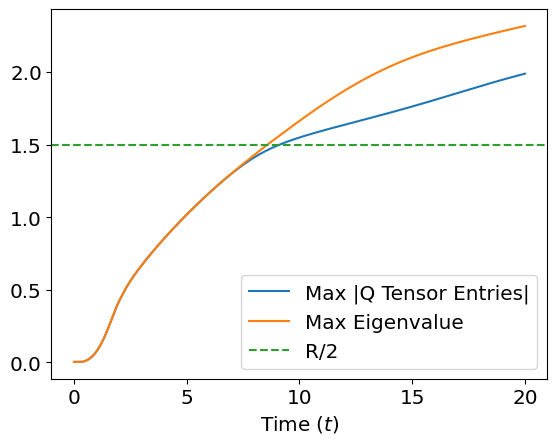

In [15]:
plt.plot(np.arange(len(max_entries_t))*dt, max_entries_t, label='Max |Q Tensor Entries|')
plt.plot(np.arange(len(eigenvalue_2))*dt, np.max(eigenvalue_2, axis=1), label='Max Eigenvalue')
plt.axhline(y=R/2, xmin=0, xmax=T, color="C2", linestyle="--", label="R/2")
plt.xlabel("Time ($t$)")
plt.legend()
plt.savefig("./Experiment2b-Plots/experiment2b_eigenvalues.pdf", bbox_inches='tight')